In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from numpy import linalg as LA

import math
from scipy.integrate import quad

Spin boson model solution (based on Gernot's Example: https://www1.itp.tu-berlin.de/schaller/download/TOQT.pdf page 136)

$ H_S= \frac{\omega}{2} \sigma_z + \frac{\Delta}{2} \sigma_x $

$ H_B= \sum_{k} \omega_k a_k ^{\dagger} a_k $

$ H_I= \sigma_z \otimes \sum t_{k}\left(a_{k}+a_{k}^{\dagger}\right)$

Exact solution:  pure-dephasing limit ($\Delta=0$)

$ H_S= \frac{\omega}{2} \sigma_z  $

$ H_B= \sum_{k} \omega_k a_k ^{\dagger} a_k $

$ H_I= \sigma_z \otimes \sum t_{k}\left(a_{k}+a_{k}^{\dagger}\right)$ 

The populatios remain unafected since $H_I$ conmustes with $H_S$, but the coherenes decay accroding to(in the interaction picture) : 

$\rho_{01}(t)=\exp \left\{-\frac{4}{\pi} \int_{0}^{\infty} J^{(0)}(\omega) \frac{\sin ^{2}(\omega t / 2)}{\omega^{2}} \operatorname{coth}\left(\frac{\beta \omega}{2}\right) d \omega\right\} \rho_{01}^{0}$


We will use this example for spectral densury 


$J^{(0)}(\omega)=2 \pi \sum_{k}\left|t_{k}\right|^{2} \delta\left(\omega-\omega_{k}\right)=\Gamma \frac{\omega \delta^{7}}{\left[(\omega-\epsilon)^{2}+\delta^{2}\right]^{2}\left[(\omega+\epsilon)^{2}+\delta^{2}\right]^{2}}$

with this paremeters:

$\mathbf{\Gamma} \beta=10000, \delta \beta=\mathbf{1}, \boldsymbol{\epsilon} \beta=2, \omega \beta=1$

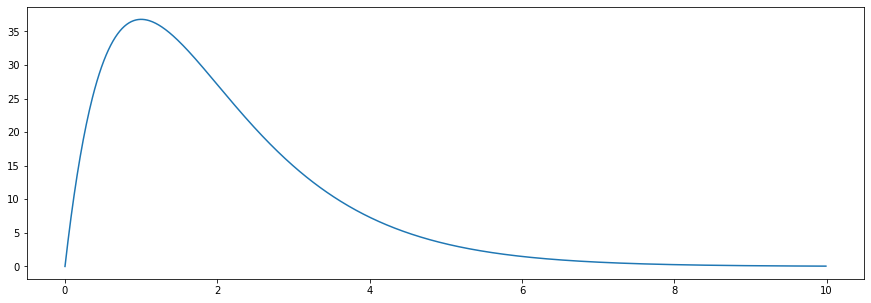

In [52]:
#set 1
#beta= 1.0
#Gamma=  10000.0/beta
#delta= 1.0/beta
#epsilon = 2.0 /beta 
#omega=1.0/beta

#set 2
beta= 1.0
Gamma=  100.0/beta
omega_c=1.0/beta
omega=10.0/beta


rho_01_init=0.5

def J(w):
    return Gamma * w *np.exp(-w/omega_c )

#print (J(0.0))
vecfunc = np.vectorize(J)
w = np.arange(0.0, 10.0, 0.01)
T = vecfunc(w)
plt.plot (w, T)
plt.show()

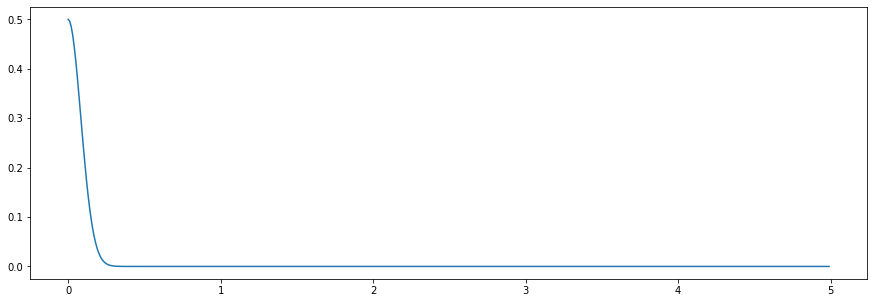

In [53]:


def integrand(w, t):
    return J(w)* (np.sin(w*t/2))**2 / (w**2)  / np.tanh (beta*w /2 )


def expint(t):
    return quad(integrand, 0, np.inf, args=(t))[0]


def rho_01(t):
    return np.exp(-4.0/np.pi * expint(t) ) * rho_01_init

vecfunc = np.vectorize(rho_01)
t1 = np.arange(0.0, 5.0, 0.01)
T1 = vecfunc(t1)
plt.plot (t1, T1)
plt.show()

Now we apply the reaccion coodinate mapping :

$  H_0= \frac{\omega}{2} \sigma_z +  \Omega_0 b ^{\dagger} b +g \sigma_z  \left( b + b ^{\dagger} \right) + \frac{g^2}{\Omega} \sigma_z^2 + \Omega \Delta_{RC} \left( b + b ^{\dagger} \right)^2$

$   H_B= \sum_{k} \Omega_k b_k ^{\dagger} b_k $

$   H_I= \left( b + b ^{\dagger} \right) \sum_k h_k \left( b_k + b_k ^{\dagger} \right)$

where the energy of the RC and the coupling strength become:

$\Omega_{0}^{2}=\frac{\left(\delta^{2}+\epsilon^{2}\right)^{2}}{5 \delta^{2}+\epsilon^{2}}, \quad g^{2}=\frac{\Gamma \delta^{4} \sqrt{5 \delta^{2}+\epsilon^{2}}}{64\left(\delta^{2}+\epsilon^{2}\right)^{2}}
$


The mapping transformation can be computed explicitly, where the transformed spectral density becomes ohmic:

$ J^{(1)}(\omega)=\frac{16 \omega \delta^{3} \sqrt{5 \delta^{2}+\epsilon^{2}}}{\omega^{4}+\omega^{2}\left(6 \delta^{2}-2 \epsilon^{2}\right)+\left(5 \delta^{2}+\epsilon^{2}\right)^{2}} $


And the renormalization energy as $\Delta_{RC}$: 

$\Omega_{0} \cdot \Delta_{RC} \equiv \sum_{k} \frac{h_{k}^{2}}{\Omega_{k}}=\frac{1}{2 \pi} \int_{0}^{\infty} \frac{J^{(1)}(\omega)}{\omega} d \omega$



In [62]:
##We build the supersystem Hamiltonian with N_RC number of modes for the RC

N_RC = 100 # number of basis states to consider
b = destroy(N_RC)

Omega_Rc=np.sqrt( 2.0 )
g=np.sqrt( 22.5079 )
print(Omega_Rc)

#def J_1(w):
#    return (16*w*delta**3*np.sqrt(5*delta**2+ epsilon**2))/(w**4+w**2*(6*delta**2-2*epsilon**2)+ (5*delta**2+epsilon**2)**2)

#vecfunc = np.vectorize(J_1)
#w = np.arange(0.0, 10.0, 0.01)
#T = vecfunc(w)
#plt.plot (w, T)
#plt.show()

#def integrand(w):
#    return  J_1(w)/w

#Delta_Rc = (1/(2*np.pi*Omega_Rc))* quad(integrand, 0, np.inf)[0]
Delta_Rc2=0
print(Omega_Rc,g,Delta_Rc2)

H0= omega/2 *tensor(sigmaz(), identity(N_RC) )  + Omega_Rc *tensor(identity(2) , b.dag() * b )  + g* tensor(sigmaz(),  b.dag() + b ) + Omega_Rc*Delta_Rc2 *tensor(identity(2) , (b.dag() + b)*(b.dag() + b) )  

1.4142135623730951
1.4142135623730951 4.744249150287113 0


In order to aplly the master equation we need to preapre the initial state as: 

$\rho_{0}=\rho_{S}^{0} \otimes \frac{e^{-\beta \Omega\left[b^{\dagger} b+\Delta_{Rc}\left(b+b^{\dagger}\right)^{2}\right]}}{Z_{R C}}$

In [63]:
##Rc inicial state Thermal  
H1 = b.dag() * b
H2 = Delta_Rc2*(b.dag()+ b)*(b.dag()+ b)  ##Auxliar Hamiltonians
H_Rc= -beta*Omega_Rc*(H1+H2)
Exp= H_Rc.expm()
Z_Rc=Exp.tr()
rho_Rc_init=Exp/Z_Rc

#print(rho_Rc_init)

#Sistem inital state
psi0 = (1/np.sqrt(2.)) * (basis(2, 0) + basis(2, 1) )
#psi0 =  basis(2, 0) 

##Spin Inicial state 
rho_Spin= psi0*psi0.dag()
#print(rho_Spin)

###Tensor producto of the initial state
rho_init=tensor(rho_Spin,rho_Rc_init) 

print(rho_init.ptrace(0))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


The evolutions is given by the master equation (in the interaction picture):

$\dot{\boldsymbol{\rho}}_{0}(t)=\gamma' \left(b \boldsymbol{\rho}_{0}(t) b^{\dagger}-\frac{1}{2}\left\{b^{\dagger} b, \boldsymbol{\rho}_{0}(t)\right\}\right)+\bar{\gamma}' \left(b^{\dagger} \boldsymbol{\rho}_{0}(t) b-\frac{1}{2}\left\{b b^{\dagger}, \boldsymbol{\rho}_{0}(t)\right\}\right)-\mathrm{i}\left[\frac{\sigma}{2} b^{\dagger} b+\frac{\bar{\sigma}}{2} b b^{\dagger}, \boldsymbol{\rho}_{0}(t)\right]$


where $\gamma'=J(\Omega)\left[1+n_{B}(\Omega)\right]$ , $ \bar{\gamma}' = J(\Omega) n_{B}(\Omega)$ and $n_{B}(\omega)=\left[e^{\beta \omega}-1\right]^{-1}$

and 
$\sigma =\sigma(\Omega)=\frac{\mathrm{i}}{\pi} \mathcal{P} \int_{-\infty}^{+\infty} \frac{\gamma(\Omega')}{\Omega-\Omega'} d \Omega'$

In [64]:
def nb(w):
    return 1/(np.exp(beta*w)-1)

#def gamma_prime(w):
#    if w==0:
#        return 0.592592
#    else:
#        return J_1(w)*(1+nb(w))

gamma_prime_n= 2.32141  *(1+nb(Omega_Rc))
gamma_bar_prime_n=    2.32141*nb(Omega_Rc)

print(gamma_prime_n,gamma_bar_prime_n )


3.06706477155985 0.7456547715598499


In [65]:
#from sympy import oo
#from sympy.integrals.integrals import Integral
#from sympy.abc import x

#Calculate the lamb Shift 
#Integral(gamma_prime(x)/(Omega_Rc-x), (x, -oo, oo)).principal_value()

aux1= gamma_prime_n/2.0 * tensor(identity(2) ,   b.dag()*b)
aux2= gamma_bar_prime_n/2.0 * tensor(identity(2) ,  b * b.dag())
aux3= g/Omega_Rc* ( gamma_prime_n/2.0 + gamma_bar_prime_n/2.0)*tensor(sigmaz() ,  b )
aux4= g/Omega_Rc* ( gamma_prime_n/2.0 + gamma_bar_prime_n/2.0)*tensor(sigmaz() ,  b.dag() )

Lamb=aux1+aux2+aux3+aux4

The decays follow the matrix 

$h= \left(\begin{array}{ccc}\gamma & 0 & \frac{g \gamma}{\Omega} \\ 0 & \bar{\gamma} & \frac{g \bar{\gamma}}{\Omega} \\ \frac{g \gamma}{\Omega} & \frac{g \bar{\gamma}}{\Omega} & \frac{g^{2}(\bar{\gamma}+\gamma)}{\Omega^{2}}\end{array}\right)$

We define the new Limbland opetaros and decays as :

$u^{\dagger} h u=\left[\begin{array}{cccc}\gamma_{1} & 0 & \cdots & 0 \\ 0 & \gamma_{2} & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \gamma_{N^{2}}\end{array}\right]$

and: 
$L_{i}=\sum_{j=1}^{N^{2}-1} u_{j i} A_{j}$ i.e $L = U ^{-1} A$ and the vector $A=( b, b ^{\dagger} , \sigma_z)$

In [66]:
# import sympy 
#M = Matrix([[gamma_prime_n, 0, gamma_prime_n*g/Omega_Rc], [0, gamma_bar_prime_n, g*gamma_bar_prime_n/Omega_Rc], [g*gamma_prime_n/Omega_Rc, g*gamma_bar_prime_n/Omega_Rc, g**2*(gamma_prime_n+gamma_bar_prime_n)/Omega_Rc**2]]) 

#test=np.array([[1., 2.], [3., 4.]])
MP = np.array([[gamma_prime_n, 0, gamma_prime_n*g/Omega_Rc], [0, gamma_bar_prime_n, g*gamma_bar_prime_n/Omega_Rc], [g*gamma_prime_n/Omega_Rc, g*gamma_bar_prime_n/Omega_Rc, g**2*(gamma_prime_n+gamma_bar_prime_n)/Omega_Rc**2]])

#w, v = LA.eig(test)
#print(w)
#print(v)

print(MP)

w, v = LA.eig(MP)
print(w)
#print(v)

U=np.array([[0.31174005, -0.68228824,  0.6612873 ],[0.0534015,-0.68228824,-0.72913033],[0.9486656,0.26261287,-0.17626135]])

U_1=LA.inv(U)

print(U)
print(U_1)


[[ 3.06706477  0.         10.28905381]
 [ 0.          0.74565477  2.50144116]
 [10.28905381  2.50144116 42.9081551 ]]
[4.55403412e+01 1.12487549e-15 1.18053347e+00]
[[ 0.31174005 -0.68228824  0.6612873 ]
 [ 0.0534015  -0.68228824 -0.72913033]
 [ 0.9486656   0.26261287 -0.17626135]]
[[ 0.31174006  0.05340151  0.9486656 ]
 [-0.68228824 -0.68228824  0.26261286]
 [ 0.6612873  -0.72913033 -0.17626135]]


In [67]:
A1=tensor(identity(2) ,  b )
A2=tensor(identity(2) , b.dag()  )
A3=tensor( sigmaz(), identity(N_RC)  )

print(w[1])
L1=U[0][0]*A1+U[1][0]*A2+U[2][0]*A3
L2=U[0][1]*A1+U[1][1]*A2+U[2][1]*A3
L3=U[0][2]*A1+U[1][2]*A2+U[2][2]*A3

gamma1=w[0]
gamma2=0.0 #w[1]
gamma3=w[2]

L=[np.sqrt(gamma1) * L1, np.sqrt(gamma2)*L2,  np.sqrt(gamma3)*L3]

L0=[np.sqrt(gamma_prime_n) * A1, np.sqrt(gamma_bar_prime_n)*A2 ]

1.124875491673415e-15


We find the the coherences as:

$\left|\rho_{01}\right|=\mid \frac{1}{2} \operatorname{Tr}\left\{\left(\sigma^{x}+\mathrm{i} \sigma^{y}\right) \rho(t)\right\}$

In [68]:
t0 = 0.0
tf = 5.0
time_steps = 500



## Time range
t = np.linspace(0, tf, time_steps)

result = mesolve(0*H0, rho_init, t, L0)


states_IP=result.states
exp_result=[0 for i in range(len(states_IP))]

trace=[0 for i in range(len(states_IP))]

for i in range(len(states_IP)):
    exp_result[i]=  (-1j*H0*t[i]).expm()* states_IP[i]*  (1j*H0*t[i]).expm()
    #trace[i]=  states_IP[i].ptrace(0)
    trace[i]=  exp_result[i].ptrace(0)

print(trace[0])    


p01=[0 for i in range(len(states_IP))]
for i in range(len(states_IP)):
    p01[i]=abs(expect(0.5*(sigmax()+1j*sigmay()),trace[i]))

#print(p01)  

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


Now we evolve with the following equation in order to compare: 

$\begin{aligned} \dot{\rho}=-& \mathrm{i}\left[H_{S}^{\prime}, \rho\right]-\int_{0}^{\infty} C(+\tau)\left[\left(b+b^{\dagger}\right), e^{-\mathrm{i} H_{S}^{\prime} \tau}\left(b+b^{\dagger}\right) e^{+\mathrm{i} H_{S}^{\prime} \tau} \rho(t)\right] d \tau \\ &-\int_{0}^{\infty} C(-\tau)\left[\rho(t) e^{-\mathrm{i} H_{S}^{\prime} \tau}\left(b+b^{\dagger}\right) e^{+i H_{S}^{\prime} \tau},\left(b+b^{\dagger}\right)\right] d \tau \end{aligned}$

where we need to find the supersystem Hamitionial states $H_{S}^{\prime}\left|a^{\prime}\right\rangle=E_{a}^{\prime}\left|a^{\prime}\right\rangle$, we can find:  

$\int_{0}^{\infty} C(\tau) e^{-\mathrm{i} H_{S}^{\prime} \tau}\left(b+b^{\dagger}\right) e^{+\mathrm{i} H_{S}^{\prime} \tau} d \tau=\sum_{a b}\left\langle a^{\prime}\left|\left(b+b^{\dagger}\right)\right| b^{\prime}\right\rangle \int_{0}^{\infty} C(\tau) e^{-\mathrm{i}\left(E_{a}^{\prime}-E_{b}^{\prime}\right) \tau} d \tau\left|a^{\prime}\right\rangle\left\langle b^{\prime}\right|$

where: 

$\int_{0}^{\infty} C(\tau) e^{+\mathrm{i}\left(E_{b}^{\prime}-E_{a}^{\prime}\right) \tau} d \tau =\frac{\gamma\left(E_{b}^{\prime}-E_{a}^{\prime}\right)}{2}+\frac{\mathrm{i}}{2 \pi} \mathcal{P} \int \frac{\gamma(\omega)}{E_{b}^{\prime}-E_{a}^{\prime}-\omega} d \omega$ 

where we will negecled the principal value term (lamb Shift) and $\gamma(\omega)=J(\omega)\left[1+n_{B}(\omega)\right]$

In [40]:
def nb(w):
    return 1/(np.exp(beta*w)-1)

def gamma(w):
    return J_1(w)*(1+nb(w))

  
  

all_energy, all_state = H0.eigenstates(sparse=sparse)

Nmax=N_RC*2
Limb_op1=0
Limb_op2=0
Apre = spre((b + b.dag()))
Apost = spost(b + b.dag())
for j in range(Nmax):
    for k in range(Nmax):
        A = (b + b.dag()).matrix_element(all_state[j].dag(), all_state[k])
        delE = (all_energy[j] - all_energy[k])
        X1=gamma(delE)/2
        X2=gamma(-delE)/2
        Limb_op1 = Limb_op1 + A*X1*all_state[j] * all_state[k].dag() 
        Limb_op2 = Limb_op2 + A*X2*all_state[j] * all_state[k].dag()
B=tensor(identity(2),b+ b.dag())
print(B*Limb_op1)


t0 = 0.0
tf = 1.0
time_steps = 200


L2= -spre(B* Limb_op1)+ sprepost(Limb_op1, B)-  spost(Limb_op2*B) +  sprepost( B, Limb_op2)
## Time range
t = np.linspace(0, tf, time_steps)


psi0 =  basis(2, 0)  
rho_Spin= psi0*psi0.dag()
rho_init_2=tensor(rho_Spin,rho_Rc_init)

output_2 = mesolve(H0, rho_init, t, [L2])

NameError: name 'delta' is not defined

In [ ]:
states_IP_2=output_2.states


trace_2=[0 for i in range(len(states_IP_2))]
for i in range(len(states_IP_2)):
    trace_2[i]=  states_IP_2[i].ptrace(0)

print(trace_2[0])    


p01_2=[0 for i in range(len(states_IP_2))]
for i in range(len(states_IP_2)):
    p01_2[i]=abs(expect(0.5*(sigmax()+1j*sigmay()),trace_2[i]))
    
print(p01_2[0])

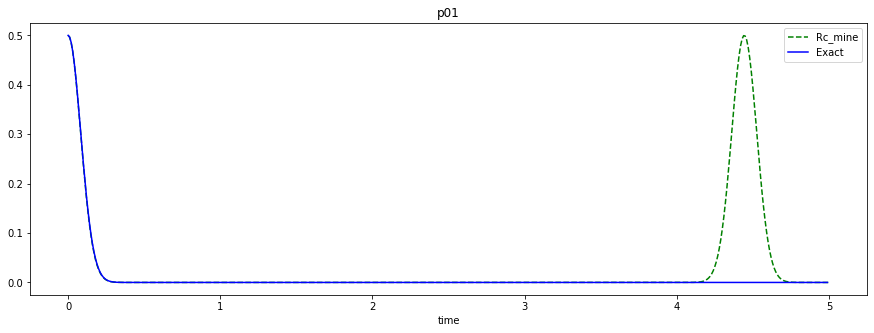

In [69]:
plt.title("p01")
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(t,p01,"--",label='Rc_mine', color = "g")
plt.plot (t1 , T1,"-",label='Exact', color = "b") 
#plt.plot(t,p01_2,"--",label='Rc_Gernot', color = "y")
#plt.plot(tlist, result.expect[0])
plt.xlabel("time")
plt.legend()
plt.show()

# 
